In [4]:
import geopandas as gp
import geohash
import pandas as pd
import numpy as np
import fiona
import json
import geog
import shapely
import shapely.geometry
from osgeo import ogr
from polygongeohasher import polygon_to_geohashes, geohashes_to_polygon
import requests
import psycopg2
from sqlalchemy import create_engine
import psycopg2
from sqlalchemy import create_engine
%autosave 0 

ModuleNotFoundError: No module named 'geopandas'

In [ ]:
import pyproj
from functools import partial
from shapely.ops import transform

In [2]:
user = 'postgres'
pwd = 'password123'
host = 'localhost'
port = 5432
db = 'ookla'
db2 = 'edotco'
# This engine just used to query for list of databases
postgreseng = create_engine('postgresql+psycopg2://{0}:{1}@{2}:{3}/{4}'.format(user, pwd, host, port,db))
postgreseng2 = create_engine('postgresql+psycopg2://{0}:{1}@{2}:{3}/{4}'.format(user, pwd, host, port,db2))
poi = pd.read_sql_table('finalpoi_v1',con=postgreseng2)
poi = pd.read_csv("poi.csv")
poi.category.value_counts()
poi.finalcat.value_counts()

NameError: name 'create_engine' is not defined

In [1]:
# STEP 1: GET THE RESPECTIVE CATEGORY 
poi = pd.read_csv("poi.csv")
poi_fin = poi[poi['finalcat'] == 'Financial Institutions'][['latitude','longitude']]
poi_fin.reset_index(inplace=True)

NameError: name 'pd' is not defined

In [309]:
# STEP 2: CREATE CIRLE 1 KM 
def createCirle(lat,long,radius): # radius in meter measurement 
    p = shapely.geometry.Point([long, lat])
    n_points = 20
    d = radius #10 * 1000  # meters
    angles = np.linspace(0, 360, n_points)
    polygon = geog.propagate(p, angles, d)
    #return ogr.CreateGeometryFromJson(json.dumps(shapely.geometry.mapping(shapely.geometry.Polygon(polygon))))
    return shapely.geometry.mapping(shapely.geometry.Polygon(polygon))
poi_fin['circle'] = poi.apply(lambda x: createCirle(x['latitude'],x['longitude'],1000),axis=1)

In [305]:
# STEP 3: CONVERT THE CRICLE ABOVE INTO POLYGON
def convert2shapely(js):
    shapely_polygon = shapely.geometry.Polygon(list(js['coordinates'][0]))
    return gp.GeoSeries([shapely_polygon])
poi_fin['geometry'] = poi_fin['circle'].apply(lambda x: convert2shapely(x))

In [307]:
poi_fin.head(2)

,index,latitude,longitude,circle,geometry
0,45,22.949900,97.746000,"{'type': 'Polygon', 'coordinates': (((96.18320...","POLYGON ((96.18320608442839 16.83874978638753,..."
1,67,16.777815,96.151357,"{'type': 'Polygon', 'coordinates': (((96.13845...","POLYGON ((96.13845207912325 16.82856548652448,..."


In [308]:
# STEP 4: GET THE RESPECITVE GEOHASH INSIDE EACH CIRCLE POLYGON
poi_fin['geohash'] = poi_fin['geometry'].apply(lambda x:polygon_to_geohashes(x,7))

In [311]:
poi_fin.head()

,index,latitude,longitude,circle,geometry,geohash
0,45,22.949900,97.746000,"{'type': 'Polygon', 'coordinates': (((96.18320...","POLYGON ((96.18320608442839 16.83874978638753,...","{w4uru9u, w4uru84, w4uru3u, w4uru6q, w4uru9s, ..."
1,67,16.777815,96.151357,"{'type': 'Polygon', 'coordinates': (((96.13845...","POLYGON ((96.13845207912325 16.82856548652448,...","{w4urern, w4urers, w4urg2r, w4urer6, w4ureru, ..."
2,132,16.145002,94.758555,"{'type': 'Polygon', 'coordinates': (((96.20077...","POLYGON ((96.20077608993772 16.83886078638604,...","{w4urub2, w4urudp, w4uruc3, w4urubq, w4urubf, ..."
3,169,20.813400,95.771500,"{'type': 'Polygon', 'coordinates': (((96.18310...","POLYGON ((96.18310090079291 16.77446578725165,...","{w4urkwc, w4urkwk, w4urktv, w4urkky, w4urkt3, ..."
4,272,16.608285,94.927038,"{'type': 'Polygon', 'coordinates': (((96.13838...","POLYGON ((96.138388694982 16.81072878676427, 9...","{w4uresg, w4ureks, w4uree3, w4urek3, w4ures6, ..."


In [312]:
type(poi_fin)

pandas.core.frame.DataFrame

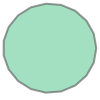

In [313]:
poi_fin['geometry'][3]

In [318]:
# STEP 7: SAVE THE FILES 
poi_fin.to_csv("poi_fin",index=False)

In [5]:
poi_fin.head(3)

NameError: name 'poi_fin' is not defined

In [314]:
# STEP 6: CONVERT INTO GEODATAFRAME
poi_fin_1km = gp.GeoDataFrame(poi_fin,crs='epsg:4326',geometry=poi_fin['geometry'])

In [ ]:
# STEP 6: SAVE THE FILES 
del poi_fin_1km['index']

In [ ]:
poi_fin_1km.to_file("poi_fin_1km")

In [ ]:
del poi_fin_1km['circle']

In [ ]:
poi_fin_1km.dtypes